In [1]:
%matplotlib inline

In [2]:
import os
import pathlib
import sys

In [3]:
base_path = pathlib.Path(os.getcwd())
base_path = str(base_path.parent)
sys.path = [base_path] + sys.path

In [4]:
import pickle
import random as python_random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import model_to_dot
from tensorflow.python.keras.utils import tf_utils
from IPython.display import SVG

In [6]:
sns.set(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1.0, color_codes=True)

In [7]:
os.makedirs("./img/", exist_ok=True)
os.makedirs("./model/", exist_ok=True)

In [8]:
seed = 6902

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(seed)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed)

In [9]:
from pynvml import *

try:
    nvmlInit()
    print("Driver Version:", nvmlSystemGetDriverVersion())
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
    nvmlShutdown()
except NVMLError as error:
    print(error)

Driver Version: b'419.17'
Device 0 : b'GeForce GTX 1070 Ti'


In [10]:
from cpuinfo import get_cpu_info

for key, value in get_cpu_info().items():
    print("{0}: {1}".format(key, value))

python_version: 3.6.10.final.0 (64 bit)
cpuinfo_version: [7, 0, 0]
cpuinfo_version_string: 7.0.0
arch: X86_64
bits: 64
count: 12
arch_string_raw: AMD64
vendor_id_raw: GenuineIntel
brand_raw: Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz
hz_advertised_friendly: 3.2000 GHz
hz_actual_friendly: 3.1920 GHz
hz_advertised: [3200000000, 0]
hz_actual: [3192000000, 0]
l2_cache_size: 1572864
stepping: 10
model: 158
family: 6
l3_cache_size: 12582912
flags: ['3dnow', '3dnowprefetch', 'abm', 'acpi', 'adx', 'aes', 'apic', 'avx', 'avx2', 'bmi1', 'bmi2', 'clflush', 'clflushopt', 'cmov', 'cx16', 'cx8', 'de', 'dtes64', 'dts', 'erms', 'est', 'f16c', 'fma', 'fpu', 'fxsr', 'hle', 'ht', 'hypervisor', 'ia64', 'invpcid', 'lahf_lm', 'mca', 'mce', 'mmx', 'movbe', 'mpx', 'msr', 'mtrr', 'osxsave', 'pae', 'pat', 'pbe', 'pcid', 'pclmulqdq', 'pdcm', 'pge', 'pni', 'popcnt', 'pse', 'pse36', 'rdrnd', 'rdseed', 'rtm', 'sep', 'serial', 'smap', 'smep', 'ss', 'sse', 'sse2', 'sse4_1', 'sse4_2', 'ssse3', 'tm', 'tm2', 'tsc', 'vme', 

In [11]:
import psutil 

mem = psutil.virtual_memory() 
print("memory: {0:.2f}GB".format(mem.total / 1024**3))

memory: 15.92GB


In [12]:
SKIP_TRAIN = False

In [13]:
class Args(object):
    model_type = "medium-tied"
    seq_length = 35
    batch_size = 20
    lr = 1.0
    lr_decay = 1.2
    lr_epoch = 6
    max_grad_norm = 5.0
    hidden_size = 650
    weight_decay = 1.0e-7
    drop_rate_i = 0.35  # dropout rate for lstm x
    drop_rate_o = 0.35  # dropout rate for dense
    drop_rate_x = 0.20  # dropout rate for embeddings
    drop_rate_h = 0.20  # dropout rate for lstm h
    implementation = 2  # tied
    max_epochs = 39
    save_model = "model/{}.h5".format(model_type)
    
# class Args(object):
#     model_type = "medium-untied"
#     seq_length = 35
#     batch_size = 20
#     lr = 1.0
#     lr_decay = 1.2
#     lr_epoch = 6
#     max_grad_norm = 5.0
#     hidden_size = 650
#     weight_decay = 1.0e-7
#     drop_rate_i = 0.35  # dropout rate for lstm x
#     drop_rate_o = 0.35  # dropout rate for dense
#     drop_rate_x = 0.20  # dropout rate for embeddings
#     drop_rate_h = 0.20  # dropout rate for lstm h
#     implementation = 1  # untied
#     max_epochs = 39    
#     save_model = "model/{}.h5".format(model_type)

In [14]:
class EmbeddingDropout(keras.layers.Embedding):

    def __init__(
        self,
        input_dim,
        output_dim,
        rate,
        embeddings_initializer="uniform",
        embeddings_regularizer=None,
        activity_regularizer=None,
        embeddings_constraint=None,
        mask_zero=False,
        input_length=None,
        seed=None,
        **kwargs
    ):
        super(EmbeddingDropout, self).__init__(
            input_dim,
            output_dim,
            embeddings_initializer=embeddings_initializer,
            embeddings_regularizer=embeddings_regularizer,
            activity_regularizer=activity_regularizer,
            embeddings_constraint=embeddings_constraint,
            mask_zero=mask_zero,
            input_length=input_length,
            **kwargs
        )
        self.rate = min(1.0, max(0.0, rate))
        self.seed = seed

    def call(self, inputs, training=None):
        if training is None:
            training = K.learning_phase()

        retain_prob = 1.0 - self.rate

        dtype = K.dtype(inputs)
        if dtype != "int32" and dtype != "int64":
            inputs = tf.cast(inputs, "int32")

        def original_embedding():
            def in_train():
                binary = K.random_binomial(
                    (self.input_dim, 1),
                    p=retain_prob,
                    dtype=K.dtype(self.embeddings),
                    seed=self.seed,
                )
                dropped_embeddings = binary * self.embeddings / retain_prob
                out = tf.nn.embedding_lookup(dropped_embeddings, inputs)
                return out

            def in_test():
                out = tf.nn.embedding_lookup(self.embeddings, inputs)
                return out

            return tf_utils.smart_cond(training, in_train, in_test)

        return original_embedding()

    def get_config(self):
        config = {"rate": self.rate, "seed": self.seed}
        base_config = super(EmbeddingDropout, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [15]:
def cross_sentence_preproc(text):
    return text.replace("\n", " <eos> ")


def tokenize_txt_cross_sentence(textfile):
    # open the file as read only
    file = open(textfile, "r", encoding="UTF-8")
    # read all text
    text = file.read()
    file.close()
    print("\nSample of original txt:\n\n", text[:300])

    # run text preprocessing
    text_proc = cross_sentence_preproc(text)
    print("\nSample of processed txt:\n\n", text_proc[:300])
    print("\nTotal tokens in text: %d" % len(text_proc.split()))
    print("Unique tokens in text: %d" % len(set(text_proc.split())))

    # fit tokenizer
    tokenizer = keras.preprocessing.text.Tokenizer(filters="", lower=False)
    tokenizer.fit_on_texts([text_proc])
    # saving tokenizer
    with open(
        "data/cs-{0}.pickle".format(os.path.splitext(os.path.basename(textfile))[0]), "wb",
    ) as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


def txt_to_tensor_cross_sent_LSTM(textfile, tokenizer, batch_size=20, seq_length=35):
    PAD_VALUE = 0

    # open the file as read only
    file = open(textfile, "r", encoding="UTF-8")

    # read all text
    text = file.read()
    file.close()
    print("\nSample of original txt:\n\n", text[:300])

    # run text preprocessing
    text_proc = cross_sentence_preproc(text)
    print("\nSample of processed txt:\n\n", text_proc[:300])
    print("\nTotal tokens in text: %d" % len(text_proc.split()))
    print("Unique tokens in text: %d" % len(set(text_proc.split())))

    # load tokenizer
    with open(tokenizer, "rb") as handle:
        tokenizer = pickle.load(handle)

    # vocabulary size
    vocab_size = len(tokenizer.word_index) + 1
    print("Vocab size: %d" % vocab_size)

    # coding text
    text_coded = tokenizer.texts_to_sequences([text_proc])
    text_coded_len = len(text_coded[0])
    print("Coded text length:", text_coded_len)

    # pad according to current batch size and seq length (stateful training requirement!)
    padding_length = (
        batch_size * seq_length * ((text_coded_len // (batch_size * seq_length)) + 1)
    )
    input_array = keras.preprocessing.sequence.pad_sequences(
        text_coded, padding="post", maxlen=padding_length, value=PAD_VALUE
    )[0, :]
    print("Padded input array shape:", input_array.shape)

    # creat target array from input array
    target_array = input_array.copy()
    target_array[0:-1] = input_array[1:]
    target_array[-1] = PAD_VALUE  # value for padding

    # reshaping input and target array to fit stateful training
    # reshaping according to batch_size
    input_array = input_array.reshape((batch_size, -1))
    target_array = target_array.reshape((batch_size, -1))
    # creating list of batches (link: ...)
    x_batches = np.split(input_array, input_array.shape[1] // seq_length, axis=1)
    y_batches = np.split(target_array, target_array.shape[1] // seq_length, axis=1)
    assert len(x_batches) == len(y_batches)

    # concatenting list of batches (fit instead of fit generator)
    X = np.concatenate(x_batches)
    y = np.concatenate(y_batches)
    # additional rank for y array (Keras requirement)
    y = y.reshape(y.shape[0], y.shape[1], 1)

    print("Input tensor shape:", X.shape)
    print("Target tensor shape:", y.shape)

    return X, y, vocab_size

In [16]:
def create_bayes_model(
    input_shape,
    batch_size,
    vocab_size,
    hidden_size,
    weight_decay,
    drop_rate_i,
    drop_rate_o,
    drop_rate_x,
    drop_rate_h,
    implementation,
):
    inputs = keras.Input(shape=input_shape, batch_size=batch_size)
    embedding = EmbeddingDropout(
        vocab_size,
        hidden_size,
        drop_rate_x,
        embeddings_regularizer=keras.regularizers.l2(weight_decay),
    )
    lstm1 = layers.LSTM(
        hidden_size,
        activation="tanh",
        recurrent_activation="sigmoid",
        dropout=drop_rate_i,
        recurrent_dropout=drop_rate_h,
        kernel_regularizer=keras.regularizers.l2(weight_decay),
        recurrent_regularizer=keras.regularizers.l2(weight_decay),
        return_sequences=True,
        stateful=True,
        implementation=implementation,
    )
    lstm2 = layers.LSTM(
        hidden_size,
        activation="tanh",
        recurrent_activation="sigmoid",
        dropout=drop_rate_i,
        recurrent_dropout=drop_rate_h,
        kernel_regularizer=keras.regularizers.l2(weight_decay),
        recurrent_regularizer=keras.regularizers.l2(weight_decay),
        return_sequences=True,
        stateful=True,
        implementation=implementation,
    )
    drop = layers.Dropout(rate=drop_rate_o)
    dense = layers.Dense(
        vocab_size,
        kernel_regularizer=keras.regularizers.l2(weight_decay),
        activation="softmax",
    )
    dist = layers.TimeDistributed(dense)

    x = embedding(inputs)
    x = lstm1(x)
    x = lstm2(x)
    x = drop(x)
    output = dist(x)

    model = keras.Model(inputs=inputs, outputs=output)

    return model


class gSGD(keras.optimizers.SGD):
    def __init__(
        self,
        learning_rate=0.01,
        momentum=0.0,
        nesterov=False,
        clipglobalnorm=5.0,
        name="SGD",
        **kwargs
    ):
        super(gSGD, self).__init__(
            learning_rate=learning_rate,
            momentum=momentum,
            nesterov=nesterov,
            name=name,
            **kwargs
        )
        self.clipglobalnorm = clipglobalnorm

    def apply_gradients(self, grads_and_vars, name=None):
        """Apply gradients to variables.
        This is the second part of `minimize()`. It returns an `Operation` that
        applies gradients.
        Args:
        grads_and_vars: List of (gradient, variable) pairs.
        name: Optional name for the returned operation.  Default to the name
            passed to the `Optimizer` constructor.
        Returns:
        An `Operation` that applies the specified gradients. The `iterations`
        will be automatically increased by 1.
        Raises:
        TypeError: If `grads_and_vars` is malformed.
        ValueError: If none of the variables have gradients.
        """
        import functools
        from tensorflow.python.keras.optimizer_v2.optimizer_v2 import _filter_grads
        from tensorflow.python.distribute import (
            distribution_strategy_context as distribute_ctx,
        )

        grads_and_vars = _filter_grads(grads_and_vars)
        var_list = [v for (_, v) in grads_and_vars]
        grads = [g for (g, _) in grads_and_vars]
        grads, _ = tf.clip_by_global_norm(grads, self.clipglobalnorm)
        grads_and_vars = list(zip(grads, var_list))

        with K.name_scope(self._name):
            # Create iteration if necessary.
            with tf.init_scope():
                _ = self.iterations
                self._create_hypers()
                self._create_slots(var_list)

            if not grads_and_vars:
                # Distribution strategy does not support reducing an empty list of
                # gradients
                return tf.no_op()
            apply_state = self._prepare(var_list)
            return distribute_ctx.get_replica_context().merge_call(
                functools.partial(self._distributed_apply, apply_state=apply_state),
                args=(grads_and_vars,),
                kwargs={"name": name},
            )


def sparse_categorical_crossentropy_pad0(y_true, y_pred):
    loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    y_true = K.cast(y_true, tf.int64)
    not_pad_mask = K.greater(y_true, 0)
    not_pad_mask = K.cast(not_pad_mask, K.dtype(loss))
    not_pad_mask = K.reshape(not_pad_mask, K.shape(loss))
    loss = not_pad_mask * loss

    return K.sum(K.mean(loss, axis=0))


class SparseCategoricalCrossentropyPad0(keras.metrics.Metric):
    def __init__(self, name="SparseCategoricalCrossentropyPad0", **kwargs):
        super(SparseCategoricalCrossentropyPad0, self).__init__(name=name, **kwargs)
        self.loss = self.add_weight(name="loss", initializer="zeros")
        self.num_not_pad = self.add_weight(name="num_not_pad", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        y_true = K.cast(y_true, tf.int64)
        not_pad_mask = K.greater(y_true, 0)
        not_pad_mask = K.cast(not_pad_mask, K.dtype(loss))
        not_pad_mask = K.reshape(not_pad_mask, K.shape(loss))
        loss = not_pad_mask * loss

        self.loss.assign_add(K.sum(loss))
        self.num_not_pad.assign_add(K.sum(not_pad_mask))

    def result(self):
        return self.loss / K.maximum(1.0, self.num_not_pad)

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.loss.assign(0.0)
        self.num_not_pad.assign(0.0)

In [17]:
args = Args()

In [18]:
train_txt = "data/ptb.train.txt"
val_txt = "data/ptb.valid.txt"
test_txt = "data/ptb.test.txt"
tokenize_txt_cross_sentence(train_txt)
tokenizer = "data/cs-ptb.train.pickle"

x_train, y_train, vocab_size = txt_to_tensor_cross_sent_LSTM(
    train_txt, tokenizer, args.batch_size, args.seq_length
)
x_val, y_val, _ = txt_to_tensor_cross_sent_LSTM(
    val_txt, tokenizer, args.batch_size, args.seq_length
)
x_test, y_test, _ = txt_to_tensor_cross_sent_LSTM(
    test_txt, tokenizer, args.batch_size, args.seq_length
)


Sample of original txt:

  aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter 
 pierre <unk> N years old will join the board as a nonexecutive director nov. N 
 mr. <unk> is chairman of <unk> n.v. the d

Sample of processed txt:

  aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter  <eos>  pierre <unk> N years old will join the board as a nonexecutive director nov. N  <eos>  mr. <unk> is chairman of <unk

Total tokens in text: 929589
Unique tokens in text: 10000

Sample of original txt:

  aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter 
 pierre <unk> N years old will join the board as a nonexecutive director nov. N 

In [19]:
model = create_bayes_model(
    (args.seq_length,),
    args.batch_size,
    vocab_size,
    args.hidden_size,
    args.weight_decay,
    args.drop_rate_i,
    args.drop_rate_o,
    args.drop_rate_x,
    args.drop_rate_h,
    args.implementation,
)

In [20]:
if not SKIP_TRAIN:
    optimizer = gSGD(learning_rate=args.lr, clipglobalnorm=args.max_grad_norm)
    model.compile(
        loss=sparse_categorical_crossentropy_pad0,
        optimizer=optimizer,
        metrics=[SparseCategoricalCrossentropyPad0(), "sparse_categorical_accuracy"],
    )

    val_losses = []
    for epoch in range(args.max_epochs):
        print("Epoch: {0:0=3}/{1:0=3}".format(epoch + 1, args.max_epochs))
        if epoch >= args.lr_epoch:
            learning_rate = K.get_value(optimizer.learning_rate) / args.lr_decay
            K.set_value(optimizer.learning_rate, learning_rate)
        print("learning_rate: {0}".format(K.get_value(optimizer.learning_rate)))
        model.reset_states()
        model.fit(
            x_train,
            y_train,
            batch_size=args.batch_size,
            epochs=1,
            shuffle=False,
            verbose=2,
        )
        model.reset_states()
        results = model.evaluate(x_val, y_val, batch_size=args.batch_size, verbose=0)
        loss = results[1]
        perplexity = np.exp(loss)
        val_losses.append(loss)
        print("val_loss: {0}".format(loss))
        print("val_perplexity: {0}".format(perplexity))

        if epoch == np.argmin(val_losses):
            model.save(args.save_model, include_optimizer=False)

Epoch: 001/039
learning_rate: 1.0
Train on 26560 samples
26560/26560 - 211s - loss: 216.8371 - SparseCategoricalCrossentropyPad0: 6.1954 - sparse_categorical_accuracy: 0.1126
val_loss: 5.447317123413086
val_perplexity: 232.13453674316406
Epoch: 002/039
learning_rate: 1.0
Train on 26560 samples
26560/26560 - 211s - loss: 191.2524 - SparseCategoricalCrossentropyPad0: 5.4643 - sparse_categorical_accuracy: 0.1657
val_loss: 5.1063032150268555
val_perplexity: 165.0590362548828
Epoch: 003/039
learning_rate: 1.0
Train on 26560 samples
26560/26560 - 211s - loss: 182.5297 - SparseCategoricalCrossentropyPad0: 5.2150 - sparse_categorical_accuracy: 0.1844
val_loss: 4.922767162322998
val_perplexity: 137.3822479248047
Epoch: 004/039
learning_rate: 1.0
Train on 26560 samples
26560/26560 - 211s - loss: 176.7400 - SparseCategoricalCrossentropyPad0: 5.0495 - sparse_categorical_accuracy: 0.1964
val_loss: 4.803992748260498
val_perplexity: 121.99655151367188
Epoch: 005/039
learning_rate: 1.0
Train on 26560 

Epoch: 034/039
learning_rate: 0.006066317204385996
Train on 26560 samples
26560/26560 - 211s - loss: 145.1414 - SparseCategoricalCrossentropyPad0: 4.1462 - sparse_categorical_accuracy: 0.2651
val_loss: 4.415287971496582
val_perplexity: 82.70565795898438
Epoch: 035/039
learning_rate: 0.0050552645698189735
Train on 26560 samples
26560/26560 - 210s - loss: 145.2493 - SparseCategoricalCrossentropyPad0: 4.1493 - sparse_categorical_accuracy: 0.2647
val_loss: 4.415131568908691
val_perplexity: 82.69271850585938
Epoch: 036/039
learning_rate: 0.0042127203196287155
Train on 26560 samples
26560/26560 - 210s - loss: 145.1941 - SparseCategoricalCrossentropyPad0: 4.1477 - sparse_categorical_accuracy: 0.2650
val_loss: 4.414928436279297
val_perplexity: 82.6759262084961
Epoch: 037/039
learning_rate: 0.0035106001887470484
Train on 26560 samples
26560/26560 - 211s - loss: 145.2218 - SparseCategoricalCrossentropyPad0: 4.1485 - sparse_categorical_accuracy: 0.2646
val_loss: 4.414916038513184
val_perplexity: 

In [21]:
custom_objects = {"EmbeddingDropout": EmbeddingDropout}
model = keras.models.load_model(args.save_model, custom_objects=custom_objects)

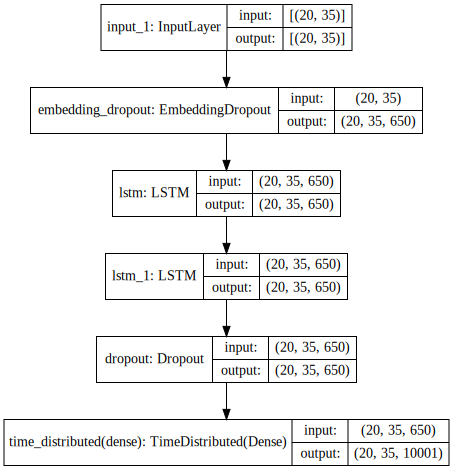

In [22]:
model_to_dot(model, show_shapes=True).write_pdf("img/ptb_architecture-nn.pdf")
SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

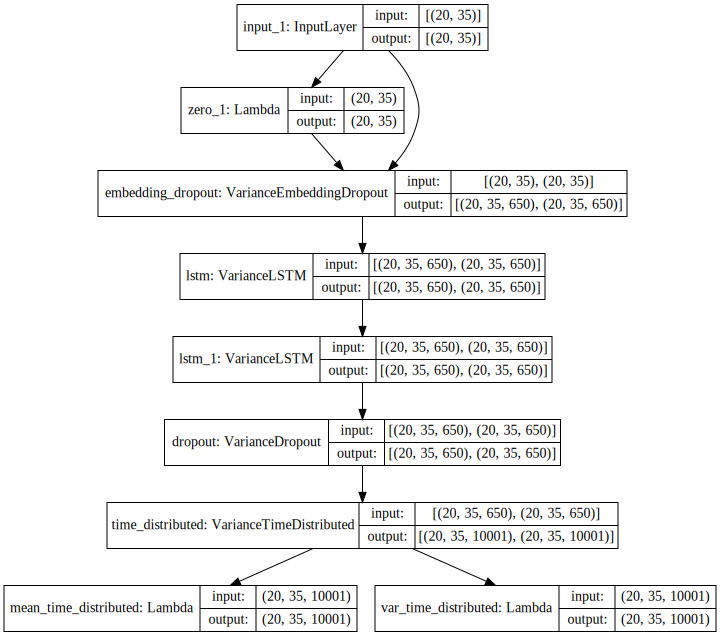

In [23]:
from vpbnn.models import nn2vpbnn
vmodel = nn2vpbnn(model, variance_mode=2)
model_to_dot(vmodel, show_shapes=True).write_pdf("img/ptb_architecture-vpbnn.pdf")
SVG(model_to_dot(vmodel, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

In [24]:
model.compile(
    loss=sparse_categorical_crossentropy_pad0,
    metrics=[SparseCategoricalCrossentropyPad0(), "sparse_categorical_accuracy"],
)

model.reset_states()
results = model.evaluate(x_val, y_val, batch_size=args.batch_size, verbose=1)
val_loss = results[1]
val_perplexity = np.exp(val_loss)

model.reset_states()
results = model.evaluate(x_test, y_test, batch_size=args.batch_size, verbose=1)
test_loss = results[1]
test_perplexity = np.exp(test_loss)

print("Normal-mode")
print("val_loss: {0}, val_perplexity: {1}".format(val_loss, val_perplexity))
print("test_loss: {0}, test_perplexity: {1}".format(test_loss, test_perplexity))

2360/2360 [==============================] - 5s 2ms/sample - loss: 152.9348 - SparseCategoricalCrossentropyPad0: 4.3779 - sparse_categorical_accuracy: 0.2742
Normal-mode
val_loss: 4.414400100708008, val_perplexity: 82.63225555419922
test_loss: 4.37785530090332, test_perplexity: 79.66698455810547


In [25]:
vmodel = nn2vpbnn(model, variance_mode=1)
vmodel.layers[-3].variance_mode = 0  # Dense.variance_mode=0
vmodel = keras.Model(inputs=vmodel.input, outputs=vmodel.output[0])

vmodel.compile(
    loss=sparse_categorical_crossentropy_pad0,
    metrics=[SparseCategoricalCrossentropyPad0(), "sparse_categorical_accuracy"],
)

vmodel.reset_states()
results = vmodel.evaluate(x_val, y_val, batch_size=args.batch_size, verbose=1)
val_loss = results[1]
val_perplexity = np.exp(val_loss)

vmodel.reset_states()
results = vmodel.evaluate(x_test, y_test, batch_size=args.batch_size, verbose=1)
test_loss = results[1]
test_perplexity = np.exp(test_loss)

print("Linear-mode")
print("val_loss: {0}, val_perplexity: {1}".format(val_loss, val_perplexity))
print("test_loss: {0}, test_perplexity: {1}".format(test_loss, test_perplexity))

2360/2360 [==============================] - 8s 3ms/sample - loss: 152.9348 - SparseCategoricalCrossentropyPad0: 4.3779 - sparse_categorical_accuracy: 0.2742 4s - loss: 154.5474 - SparseC
Linear-mode
val_loss: 4.414400100708008, val_perplexity: 82.63225555419922
test_loss: 4.37785530090332, test_perplexity: 79.66698455810547


In [26]:
vmodel = nn2vpbnn(model, variance_mode=2)
vmodel.layers[-3].variance_mode = 0  # Dense.variance_mode=0
vmodel = keras.Model(inputs=vmodel.input, outputs=vmodel.output[0])

vmodel.compile(
    loss=sparse_categorical_crossentropy_pad0,
    metrics=[SparseCategoricalCrossentropyPad0(), "sparse_categorical_accuracy"],
)

vmodel.reset_states()
results = vmodel.evaluate(x_val, y_val, batch_size=args.batch_size, verbose=1)
val_loss = results[1]
val_perplexity = np.exp(val_loss)

vmodel.reset_states()
results = vmodel.evaluate(x_test, y_test, batch_size=args.batch_size, verbose=1)
test_loss = results[1]
test_perplexity = np.exp(test_loss)

print("Independent-mode")
print("val_loss: {0}, val_perplexity: {1}".format(val_loss, val_perplexity))
print("test_loss: {0}, test_perplexity: {1}".format(test_loss, test_perplexity))

2360/2360 [==============================] - 9s 4ms/sample - loss: 152.2874 - SparseCategoricalCrossentropyPad0: 4.3593 - sparse_categorical_accuracy: 0.2735
Independent-mode
val_loss: 4.395575523376465, val_perplexity: 81.0912857055664
test_loss: 4.359323024749756, test_perplexity: 78.20417785644531


In [27]:
vmodel = nn2vpbnn(model, variance_mode=3)
vmodel.layers[-3].variance_mode = 0  # Dense.variance_mode=0
vmodel = keras.Model(inputs=vmodel.input, outputs=vmodel.output[0])

vmodel.compile(
    loss=sparse_categorical_crossentropy_pad0,
    metrics=[SparseCategoricalCrossentropyPad0(), "sparse_categorical_accuracy"],
)

vmodel.reset_states()
results = vmodel.evaluate(x_val, y_val, batch_size=args.batch_size, verbose=1)
val_loss = results[1]
val_perplexity = np.exp(val_loss)

vmodel.reset_states()
results = vmodel.evaluate(x_test, y_test, batch_size=args.batch_size, verbose=1)
test_loss = results[1]
test_perplexity = np.exp(test_loss)

print("Upper-mode")
print("val_loss: {0}, val_perplexity: {1}".format(val_loss, val_perplexity))
print("test_loss: {0}, test_perplexity: {1}".format(test_loss, test_perplexity))

2360/2360 [==============================] - 10s 4ms/sample - loss: 234.2057 - SparseCategoricalCrossentropyPad0: 6.7047 - sparse_categorical_accuracy: 0.0580
Upper-mode
val_loss: 6.784465312957764, val_perplexity: 884.0072631835938
test_loss: 6.704699516296387, test_perplexity: 816.2327270507812


Reference for implementation
- https://github.com/btarjan/stateful-LSTM-LM
- https://github.com/tensorflow/models/tree/v1.13.0/tutorials/rnn/ptb
- https://www.tensorflow.org/tutorials/text/image_captioning
- https://www.tensorflow.org/tutorials/text/nmt_with_attention
- https://github.com/yaringal/BayesianRNN
- https://github.com/wojzaremba/lstm
- https://github.com/ahmetumutdurmus/zaremba
- https://github.com/jarfo/kchar
- https://qiita.com/keisuke-nakata/items/1e43c6698df800ecad73